# Лабораторная работа 3. Классификация. Нейронные сети

## 1. Импорт библиотек и общие настройки
Подключаем все необходимые библиотеки и также создаём список `metrics_list` для последующего хранения метрик всех моделей.

In [10]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, Binarizer
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    classification_report
)

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical

# Хранилище метрик всех моделей
metrics_list = []

## 2. Загрузка датасета и первичный анализ
Этот блок отвечает за загрузку датасета и базовую проверку его структуры. Здесь отображаются первые строки таблицы, выводится информация о типах данных и количестве строк, а также проверяется, имеются ли пропуски в колонках. Далее рассчитывается описательная статистика, которая позволяет оценить диапазоны значений признаков и увидеть особенности распределений. Всё это необходимо, чтобы убедиться, что данные корректно загружены и готовы к дальнейшей обработке.

In [11]:
# Загрузка данных
data = pd.read_csv("wine_quality_classification.csv")

# Первые строки таблицы
display(data.head())

# Общая информация о датасете
print("Информация о датасете:")
data.info()

# Проверка пропусков
print("\nКоличество пропусков по столбцам:")
print(data.isnull().sum())

# Описательная статистика по числовым признакам
print("\nОписательная статистика:")
display(data.describe().round(2))

,fixed_acidity,residual_sugar,alcohol,density,quality_label
0,9.3,6.4,13.6,1.0005,high
1,11.2,2.0,14.0,0.9912,medium
2,11.6,0.9,8.2,0.9935,low
3,12.9,6.6,12.7,1.0002,low
4,13.9,13.8,10.4,0.9942,medium


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fixed_acidity   1000 non-null   float64
 1   residual_sugar  1000 non-null   float64
 2   alcohol         1000 non-null   float64
 3   density         1000 non-null   float64
 4   quality_label   1000 non-null   object 
dtypes: float64(4), object(1)
memory usage: 39.2+ KB

Количество пропусков по столбцам:
fixed_acidity     0
residual_sugar    0
alcohol           0
density           0
quality_label     0
dtype: int64

Описательная статистика:


,fixed_acidity,residual_sugar,alcohol,density
count,1000.00,1000.00,1000.00,1000.00
mean,10.17,7.69,11.04,1.00
std,3.45,4.21,1.76,0.00
min,4.00,0.50,8.00,0.99
25%,7.10,4.10,9.50,0.99
50%,10.40,7.55,11.00,1.00
75%,13.12,11.50,12.60,1.00
max,16.00,15.00,14.00,1.00


## 3. Визуализация распределений и корреляций
В этой части проводится визуальное исследование набора данных. Сначала строятся гистограммы для всех числовых признаков, что позволяет увидеть общую форму их распределений. Далее выполняется более детальный просмотр нескольких отдельных характеристик, таких как алкоголь, остаточный сахар и плотность. Отдельно визуализируется распределение целевой переменной, чтобы понять, насколько сбалансированы классы. В завершение строится корреляционная матрица, показывающая взаимосвязи между числовыми признаками и позволяющая выявить возможные зависимости, которые могут повлиять на обучение моделей.

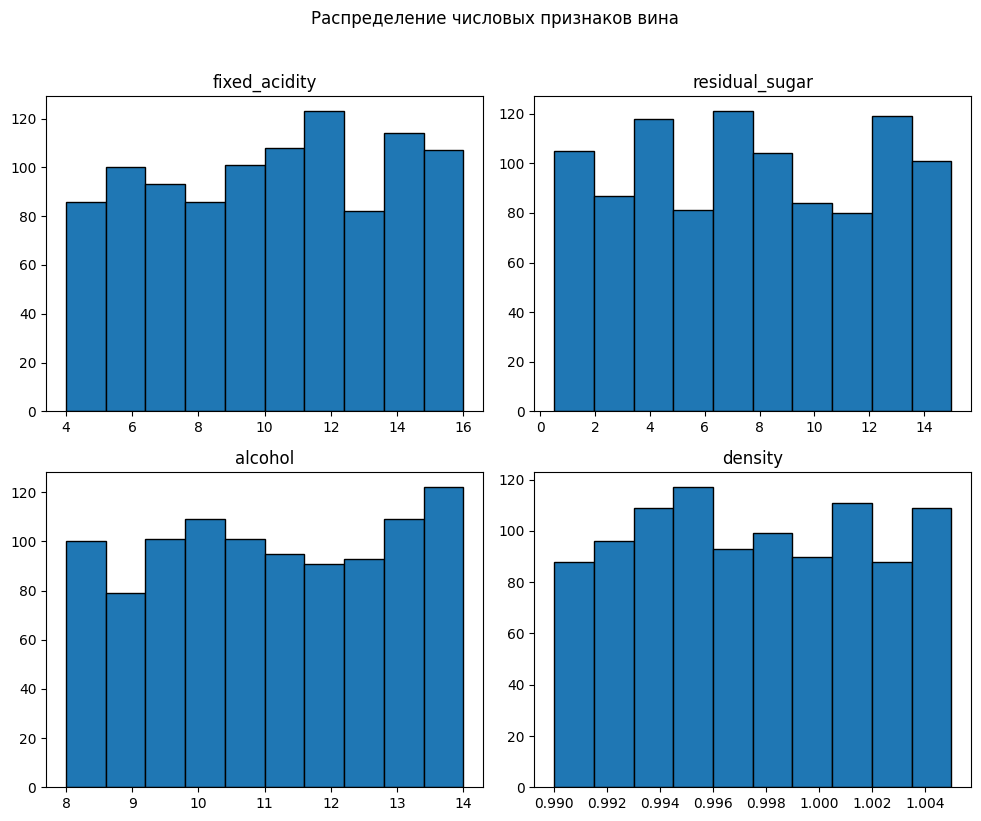

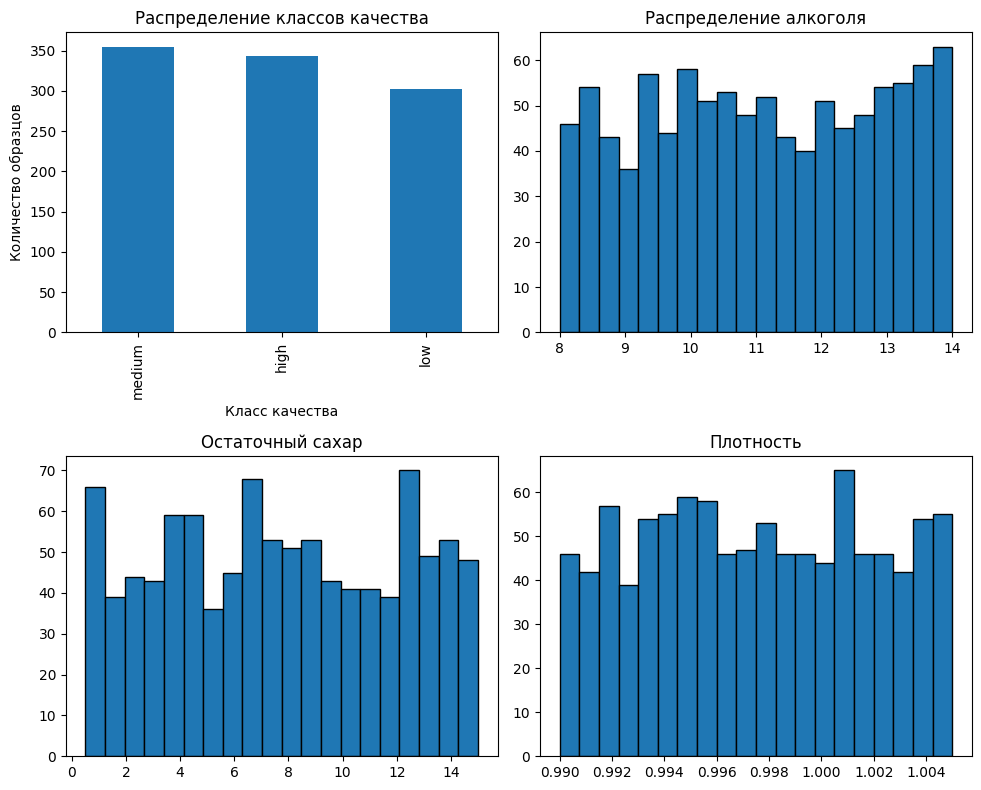

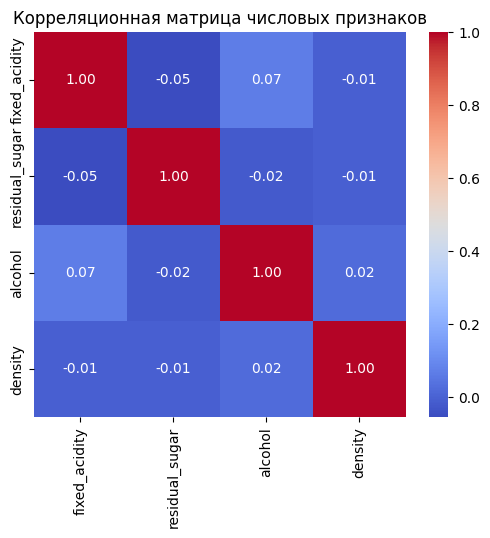

In [12]:
# Гистограммы всех числовых признаков
data.hist(edgecolor="black", figsize=(10, 8), grid=False)
plt.suptitle("Распределение числовых признаков вина", y=1.02)
plt.tight_layout()
plt.show()

# Детализированные гистограммы и распределение целевой переменной
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Распределение классов качества
data["quality_label"].value_counts().plot(
    kind="bar",
    ax=ax[0, 0]
)
ax[0, 0].set_title("Распределение классов качества")
ax[0, 0].set_xlabel("Класс качества")
ax[0, 0].set_ylabel("Количество образцов")

# Alcohol
ax[0, 1].hist(data["alcohol"], bins=20, edgecolor="black")
ax[0, 1].set_title("Распределение алкоголя")

# Residual sugar
ax[1, 0].hist(data["residual_sugar"], bins=20, edgecolor="black")
ax[1, 0].set_title("Остаточный сахар")

# Density
ax[1, 1].hist(data["density"], bins=20, edgecolor="black")
ax[1, 1].set_title("Плотность")

plt.tight_layout()
plt.show()

# Корреляционная матрица по числовым признакам (без целевой)
plt.figure(figsize=(6, 5))
sns.heatmap(
    data.drop(columns=["quality_label"]).corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Корреляционная матрица числовых признаков")
plt.show()

## 4. Подготовка данных: кодирование целевой, разделение и масштабирование
Здесь начинается подготовка данных к обучению моделей. Целевая переменная кодируется в числовой формат, поскольку алгоритмы машинного обучения не работают с текстовыми метками напрямую. Далее формируется набор признаков и разделяются данные на обучающую и тестовую выборки, что позволяет корректно оценивать качество моделей. Затем проводится масштабирование признаков, которое улучшает работу алгоритмов, чувствительных к диапазону значений. Параллельно создаётся бинаризованная версия данных для классификатора BernoulliNB, который требует бинарных входов. Этот блок завершает все необходимые преобразования перед обучением моделей.

In [13]:
# Кодирование целевой переменной (строки -> числа)
label_encoder = LabelEncoder()
data["quality_encoded"] = label_encoder.fit_transform(data["quality_label"])

# Признаки: выберем несколько основных
X = data[["fixed_acidity", "residual_sugar", "alcohol", "density"]]
y = data["quality_encoded"]

# Таблица соответствия классов и кодов
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Соответствие классов и кодов:")
print(class_mapping)

# Разбиение на train/test с сохранением пропорций классов
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nРазмер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Бинаризация признаков для BernoulliNB
binarizer = Binarizer(threshold=float(X_train.mean().mean()))
X_train_bin = binarizer.fit_transform(X_train)
X_test_bin = binarizer.transform(X_test)

Соответствие классов и кодов:
{'high': np.int64(0), 'low': np.int64(1), 'medium': np.int64(2)}

Размер обучающей выборки: (800, 4)
Размер тестовой выборки: (200, 4)


## 5. Функция оценки и обучение всех классических моделей
Этот раздел включает в себя функцию, которая обучает модели, делает предсказания и рассчитывает основные показатели качества, такие как точность, полнота, точность в прямом смысле и F1-мера. Функция также выводит матрицу ошибок и подробный отчёт по качеству классификации, что помогает понять, какие именно ошибки допускает конкретная модель. После определения универсальной функции здесь же выполняется обучение всех классических методов классификации, включая несколько вариантов наивного байесовского классификатора, дерево решений, линейный дискриминантный анализ, метод опорных векторов и алгоритм ближайших соседей. Для каждого метода фиксируются все метрики, чтобы в дальнейшем их сравнить.

In [14]:
def evaluate_model(name, model, X_train_local, X_test_local, y_train_local, y_test_local, 
                   metrics_storage, use_proba_for_roc=True):
    """
    Обучает модель, выводит confusion matrix и отчёт,
    добавляет метрики в список metrics_storage.
    """
    model.fit(X_train_local, y_train_local)
    y_pred = model.predict(X_test_local)

    acc = accuracy_score(y_test_local, y_pred)
    prec = precision_score(y_test_local, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test_local, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test_local, y_pred, average="macro", zero_division=0)

    if use_proba_for_roc and hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_local)
        try:
            roc = roc_auc_score(y_test_local, y_score, multi_class="ovr", average="macro")
        except ValueError:
            roc = np.nan
    else:
        roc = np.nan

    metrics_storage.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "roc_auc_macro_ovr": roc
    })

    print(f"\n==================== {name} ====================")
    print("Confusion matrix:")
    print(confusion_matrix(y_test_local, y_pred))
    print("\nClassification report:")
    print(classification_report(
        y_test_local,
        y_pred,
        target_names=label_encoder.classes_,
        zero_division=0
    ))

    return model


# 1. GaussianNB (работает с непрерывными признаками)
gnb = GaussianNB()
evaluate_model("GaussianNB", gnb, X_train_scaled, X_test_scaled, y_train, y_test, metrics_list)

# 2. MultinomialNB (часто для счётных признаков)
mnb = MultinomialNB()
evaluate_model("MultinomialNB", mnb, X_train, X_test, y_train, y_test, metrics_list)

# 3. ComplementNB (вариант MultinomialNB для несбалансированных классов)
cnb = ComplementNB()
evaluate_model("ComplementNB", cnb, X_train, X_test, y_train, y_test, metrics_list)

# 4. BernoulliNB (для бинарных признаков)
bnb = BernoulliNB()
evaluate_model("BernoulliNB", bnb, X_train_bin, X_test_bin, y_train, y_test, metrics_list)

# 5. Decision Tree
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    random_state=42
)
evaluate_model("DecisionTree", dt, X_train, X_test, y_train, y_test, metrics_list)

# 6. Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
evaluate_model("LDA", lda, X_train_scaled, X_test_scaled, y_train, y_test, metrics_list)

# 7. SVM с RBF-ядром
svm_clf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,
    random_state=42
)
evaluate_model("SVM (RBF kernel)", svm_clf, X_train_scaled, X_test_scaled, y_train, y_test, metrics_list)

# 8. k-Nearest Neighbors
knn = KNeighborsClassifier(
    n_neighbors=5,
    weights="uniform",
    metric="minkowski",
    p=2
)
evaluate_model("KNN (k=5)", knn, X_train_scaled, X_test_scaled, y_train, y_test, metrics_list)


==================== GaussianNB ====================
Confusion matrix:
[[31  8 30]
 [21  6 33]
 [28  6 37]]

Classification report:
              precision    recall  f1-score   support

        high       0.39      0.45      0.42        69
         low       0.30      0.10      0.15        60
      medium       0.37      0.52      0.43        71

    accuracy                           0.37       200
   macro avg       0.35      0.36      0.33       200
weighted avg       0.36      0.37      0.34       200


==================== MultinomialNB ====================
Confusion matrix:
[[34  0 35]
 [29  0 31]
 [38  0 33]]

Classification report:
              precision    recall  f1-score   support

        high       0.34      0.49      0.40        69
         low       0.00      0.00      0.00        60
      medium       0.33      0.46      0.39        71

    accuracy                           0.34       200
   macro avg       0.22      0.32      0.26       200
weighted avg       0.23 

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


## 6. Сводная таблица метрик классических моделей
В этой части собранные ранее метрики объединяются в таблицу, которая выводится на экран для удобного анализа. Далее таблица сортируется по метрике accuracy, что позволяет сразу увидеть модель, показавшую наилучший результат на данном наборе данных. Такой подход даёт возможность объективно сравнить эффективность различных алгоритмов и сделать выводы о том, какие методы работают лучше для классификации качества вина.

In [15]:
metrics_df = pd.DataFrame(metrics_list)
print("Все метрики классических моделей:")
display(metrics_df)

print("\nМодели, отсортированные по Accuracy (по убыванию):")
display(metrics_df.sort_values(by="accuracy", ascending=False))

Все метрики классических моделей:


,model,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_macro_ovr
0,GaussianNB,0.370,0.352500,0.356801,0.332952,0.518651
1,MultinomialNB,0.335,0.223322,0.319181,0.262745,0.492392
2,ComplementNB,0.325,0.303563,0.313642,0.283235,0.492429
3,BernoulliNB,0.355,0.236111,0.337144,0.275367,0.489115
4,DecisionTree,0.385,0.384781,0.383252,0.383565,0.538009
5,LDA,0.370,0.369053,0.357389,0.336112,0.494871
6,SVM (RBF kernel),0.350,0.347806,0.343410,0.336898,0.469023
7,KNN (k=5),0.310,0.304272,0.311516,0.302011,0.503373



Модели, отсортированные по Accuracy (по убыванию):


,model,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_macro_ovr
4,DecisionTree,0.385,0.384781,0.383252,0.383565,0.538009
0,GaussianNB,0.370,0.352500,0.356801,0.332952,0.518651
5,LDA,0.370,0.369053,0.357389,0.336112,0.494871
3,BernoulliNB,0.355,0.236111,0.337144,0.275367,0.489115
6,SVM (RBF kernel),0.350,0.347806,0.343410,0.336898,0.469023
1,MultinomialNB,0.335,0.223322,0.319181,0.262745,0.492392
2,ComplementNB,0.325,0.303563,0.313642,0.283235,0.492429
7,KNN (k=5),0.310,0.304272,0.311516,0.302011,0.503373


## 7. Подготовка данных и архитектуры нейронной сети
Здесь происходит подготовка данных специально для обучения нейронной сети: целевая переменная преобразуется в формат one-hot encoding, а признаки используются в масштабированном виде. Затем задаётся архитектура модели — простая полносвязная сеть с несколькими скрытыми слоями и функцией активации ReLU. На выходе используется softmax, поскольку задача является многоклассовой. После определения структуры модель компилируется, и её конфигурация выводится на экран. Этот блок полностью формирует нейросеть для дальнейшего обучения.

In [16]:
# Количество классов
num_classes = len(label_encoder.classes_)
print("Количество классов:", num_classes)

# One-hot кодирование целевой переменной
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Входные данные для сети
X_train_nn = X_train_scaled
X_test_nn = X_test_scaled

print("Форма X_train_nn:", X_train_nn.shape)
print("Форма y_train_cat:", y_train_cat.shape)

# Определение архитектуры нейронной сети
model_nn = keras.Sequential([
    layers.Input(shape=(X_train_nn.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model_nn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_nn.summary()

Количество классов: 3
Форма X_train_nn: (800, 4)
Форма y_train_cat: (800, 3)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739 (2.89 KB)

 Trainable params: 739 (2.89 KB)

 Non-trainable params: 0 (0.00 B)

## 8. Обучение нейросети, оценка и графики
В этой части нейронная сеть обучается на подготовленных данных с использованием механизма ранней остановки, который предотвращает переобучение. После завершения обучения проводится оценка модели на тестовой выборке и рассчитываются те же метрики, что и для классических алгоритмов. Они добавляются в общую таблицу, чтобы можно было сравнить нейронную сеть с другими моделями. Затем визуализируются графики изменения функции потерь и точности на протяжении эпох обучения, что позволяет понять, насколько уверенно сеть обучалась и была ли её сходимость стабильной. Этот блок завершает исследование и даёт итоговое представление о работе нейронной сети.

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3031 - loss: 1.1274 - val_accuracy: 0.3000 - val_loss: 1.1196
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3594 - loss: 1.1011 - val_accuracy: 0.3500 - val_loss: 1.1125
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3984 - loss: 1.0912 - val_accuracy: 0.3375 - val_loss: 1.1093
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3969 - loss: 1.0877 - val_accuracy: 0.3375 - val_loss: 1.1082
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3891 - loss: 1.0846 - val_accuracy: 0.3750 - val_loss: 1.1058
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3891 - loss: 1.0822 - val_accuracy: 0.3875 - val_loss: 1.1073
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4000 - loss: 1.0802 - val_accuracy: 0.3875 - val_loss: 1.1064
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4031 - loss: 1.0785 - val_accuracy: 0.3812 - 

,model,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_macro_ovr
8,Neural Network,0.405,0.418649,0.394649,0.382689,0.514218
4,DecisionTree,0.385,0.384781,0.383252,0.383565,0.538009
0,GaussianNB,0.370,0.352500,0.356801,0.332952,0.518651
5,LDA,0.370,0.369053,0.357389,0.336112,0.494871
3,BernoulliNB,0.355,0.236111,0.337144,0.275367,0.489115
6,SVM (RBF kernel),0.350,0.347806,0.343410,0.336898,0.469023
1,MultinomialNB,0.335,0.223322,0.319181,0.262745,0.492392
2,ComplementNB,0.325,0.303563,0.313642,0.283235,0.492429
7,KNN (k=5),0.310,0.304272,0.311516,0.302011,0.503373


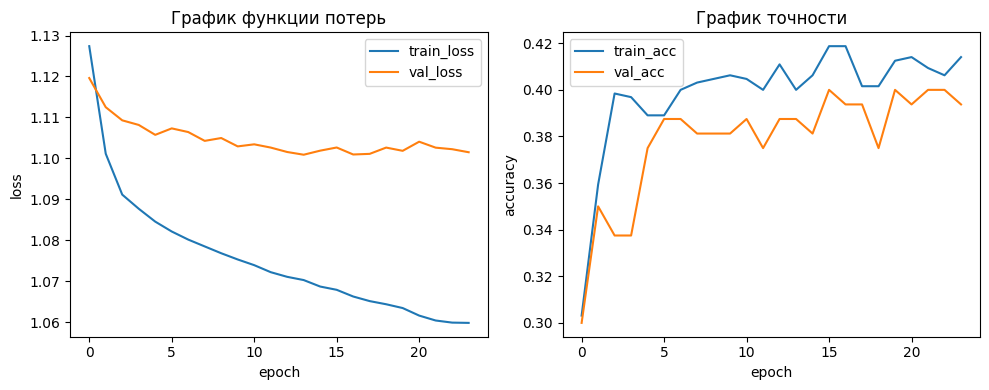

In [17]:
# Callback для ранней остановки (не пишет логи на диск)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Обучение нейронной сети (без TensorBoard и лог-файлов)
history = model_nn.fit(
    X_train_nn,
    y_train_cat,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Оценка на тестовой выборке
test_loss, test_acc = model_nn.evaluate(X_test_nn, y_test_cat, verbose=0)
print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Предсказания
y_pred_proba_nn = model_nn.predict(X_test_nn)
y_pred_nn = np.argmax(y_pred_proba_nn, axis=1)

acc_nn = accuracy_score(y_test, y_pred_nn)
prec_nn = precision_score(y_test, y_pred_nn, average="macro", zero_division=0)
rec_nn = recall_score(y_test, y_pred_nn, average="macro", zero_division=0)
f1_nn = f1_score(y_test, y_pred_nn, average="macro", zero_division=0)

try:
    roc_nn = roc_auc_score(y_test, y_pred_proba_nn, multi_class="ovr", average="macro")
except ValueError:
    roc_nn = np.nan

print("\n=== Метрики нейросети ===")
print("Accuracy:", acc_nn)
print("Precision (macro):", prec_nn)
print("Recall (macro):", rec_nn)
print("F1 (macro):", f1_nn)
print("ROC-AUC (macro, ovr):", roc_nn)

print("\nClassification report (NN):")
print(classification_report(
    y_test,
    y_pred_nn,
    target_names=label_encoder.classes_,
    zero_division=0
))

# Добавляем метрики нейросети в общий список
metrics_list.append({
    "model": "Neural Network",
    "accuracy": acc_nn,
    "precision_macro": prec_nn,
    "recall_macro": rec_nn,
    "f1_macro": f1_nn,
    "roc_auc_macro_ovr": roc_nn
})

# Обновлённая таблица метрик со всеми моделями
metrics_df = pd.DataFrame(metrics_list)
print("\nВсе модели с учётом нейросети, отсортированные по Accuracy:")
display(metrics_df.sort_values(by="accuracy", ascending=False))

# Графики обучения
history_dict = history.history

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dict["loss"], label="train_loss")
plt.plot(history_dict["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("График функции потерь")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict["accuracy"], label="train_acc")
plt.plot(history_dict["val_accuracy"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("График точности")
plt.legend()

plt.tight_layout()
plt.show()